In [243]:
import numpy as np
import scqubits as sq
import scipy.stats
import scipy.constants as const
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution
sq.settings.T1_DEFAULT_WARNING=False
sq.set_units('GHz')
%matplotlib inline

 /Users/joancaceres/anaconda3/envs/ferbo/lib/python3.11/site-packages/scqubits/core/units.py: 64

In [339]:
def fluxo(params, **kwargs):
    """
    Calculate and return a Fluxonium qubit object with specified parameters.
    
    Parameters:
    - params (tuple): A tuple containing the following parameters:
        - small_jj_area (float): The area of the small Josephson junction in µm².
        - n_junctions (int): The initial number of Josephson junctions, which will be scaled by 100.
        - flux (float): The magnetic flux through the qubit, in units where the flux quantum is 1.
    - **kwargs: Additional keyword arguments to be passed to the Fluxonium constructor.
    
    Returns:
    - A Fluxonium qubit object configured with the calculated energy scales (EC, EL, EJ) and the specified flux.
    
    This function computes the hamiltonian based on experimental constrains given in params.
    """
    small_jj_area, n_junctions,flux = params
    n_junctions = n_junctions*100
    Ec_area = 0.98
    Ej_over_area = 22.7
    El_per_junction = 33
    C0_jja = 53e-18
    Cj_jja = 28.8e-15
    Ec_small_jj = Ec_area/small_jj_area
    Ec_JJA = const.e**2/const.h/2/(n_junctions*C0_jja)
    Ec = scipy.stats.hmean([Ec_small_jj, Ec_JJA])
    El = El_per_junction/n_junctions
    Ej = Ej_over_area*small_jj_area
    return sq.Fluxonium(EC=Ec, EL=El, EJ=Ej, flux=flux, cutoff=120,**kwargs)

def calculation_C_JJA(C0, Cj, n):
    n = int(n)
    if n == 0:
        return Cj
    else:
        previous_result = calculation_C_JJA(C0, Cj, n - 1)
        return scipy.stats.hmean([C0 + previous_result, C0])

def optimizer(params):
    fluxonium = fluxo(params)
    
    Gamma2 = 1/fluxonium.t2_effective(
                        noise_channels=['tphi_1_over_f_cc','tphi_1_over_f_flux',('t1_flux_bias_line', dict(M=1000)), 't1_inductive', ('t1_quasiparticle_tunneling', dict(Delta = 0.0002))],
                        common_noise_options=dict(T=0.015)
                            )

    #TODO: Change with a better function to solve the problem of the anharmonicity continuiously
    if np.abs(fluxonium.anharmonicity()) < 0.2:
        Gamma2 = Gamma2*100
    return Gamma2


In [340]:
bounds = [(0.04, 0.2), (0.5,4),(0, 0.5)]
result = differential_evolution(func=optimizer,bounds=bounds)

In [353]:
result

 message: Optimization terminated successfully.
 success: True
     fun: 1.8320273096541036e-08
       x: [ 1.202e-01  2.181e+00  1.569e-06]
     nit: 63
    nfev: 2884

In [346]:
fluxonium = fluxo(result.x)

Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Ec: 16.31, El: 0.151, Ej: 2.728, $\\alpha =$ -0.201301')

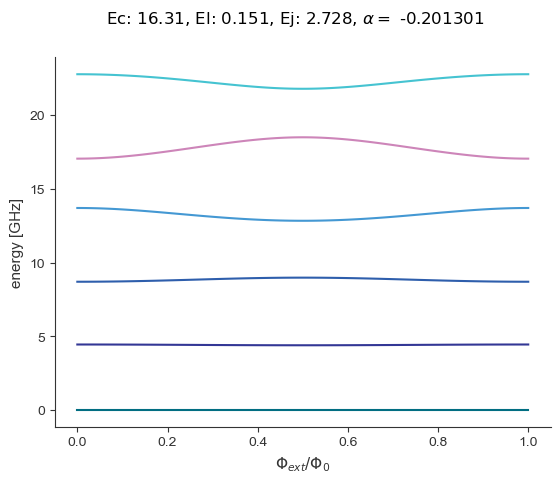

In [347]:
flux_array = np.linspace(0, 1, 101)
fig, ax = fluxonium.plot_evals_vs_paramvals('flux',flux_array, evals_count=6, subtract_ground=True)
fig.suptitle(rf'Ec: {np.round(fluxonium.EC,3)}, El: {np.round(fluxonium.EL,3)}, Ej: {np.round(fluxonium.EJ,3)}, $\alpha =$ {np.round(fluxonium.anharmonicity(),6)}')

Text(0.5, 0.98, 'Ec: 16.31, El: 0.151, Ej: 2.728, flux: 0.0')

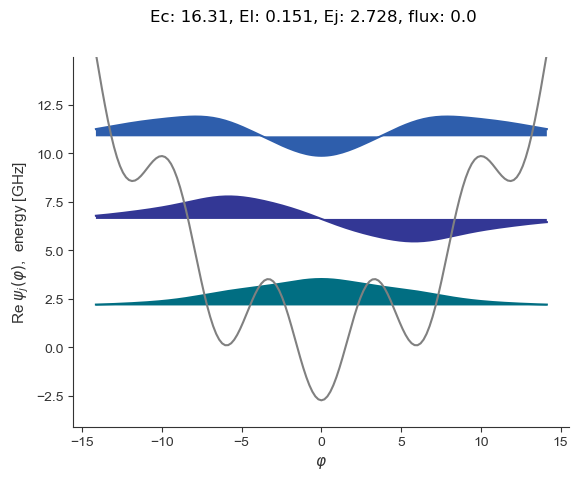

In [349]:
fig, ax = fluxonium.plot_wavefunction([0,1,2])
fig.suptitle(f'Ec: {np.round(fluxonium.EC,3)}, El: {np.round(fluxonium.EL,3)}, Ej: {np.round(fluxonium.EJ,3)}, flux: {np.round(fluxonium.flux,2)}')

Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

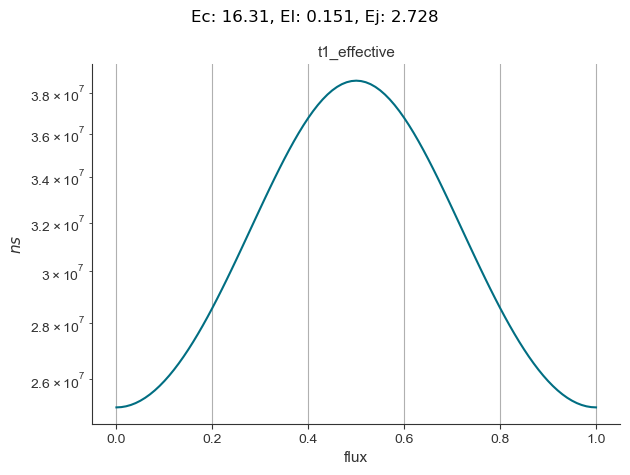

In [350]:
flux_array = np.linspace(0, 1, 101)
fig, ax = fluxonium.plot_t1_effective_vs_paramvals(param_name='flux',
                                     param_vals=flux_array,
                                     noise_channels=[('t1_flux_bias_line', dict(M=400)), 't1_inductive', 't1_quasiparticle_tunneling'],
                                     common_noise_options=dict(T=0.015)
                                     )
fig.suptitle(f'Ec: {np.round(fluxonium.EC,3)}, El: {np.round(fluxonium.EL,3)}, Ej: {np.round(fluxonium.EJ,3)}')
fig.tight_layout()

Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

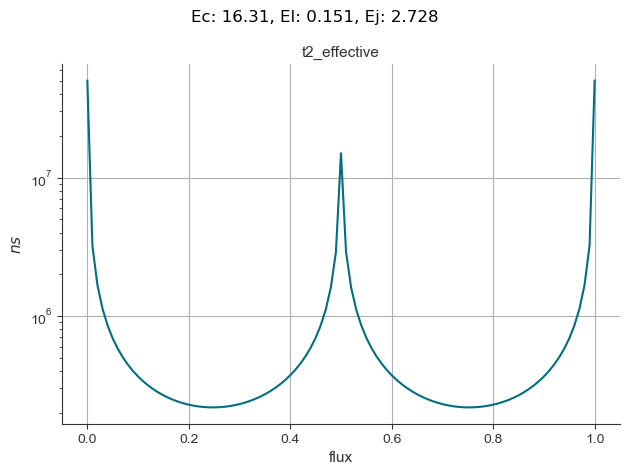

In [352]:
flux_array = np.linspace(0, 1, 101)
fig, ax = fluxonium.plot_t2_effective_vs_paramvals(param_name='flux',
                                     param_vals=flux_array,
                                     noise_channels=['tphi_1_over_f_cc','tphi_1_over_f_flux',('t1_flux_bias_line', dict(M=1000)), 't1_inductive', 't1_quasiparticle_tunneling'],
                                     common_noise_options=dict(T=0.015)
                                     )
fig.suptitle(f'Ec: {np.round(fluxonium.EC,3)}, El: {np.round(fluxonium.EL,3)}, Ej: {np.round(fluxonium.EJ,3)}')
fig.tight_layout()

In [198]:
e_charge = 1.6e-19
h = 6.62e-34
Cj = 28.8e-15
Lj = 4.62e-9
varphi = 2e-15/2/np.pi
Ec = e_charge**2/2/Cj/h*1e-9*1.46
Ej = varphi**2/Lj/h*1e-9/1.46
Ej*0.04

0.9076270384627797

In [200]:
Ej = varphi**2/Lj/h*1e-9
Ej

33.12838690389146

In [ ]:
e_charge**2/2/Cj/h*1e-9*1.46/0.04

In [333]:
blochnium.anharmonicity()

-0.39426977133654273

Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

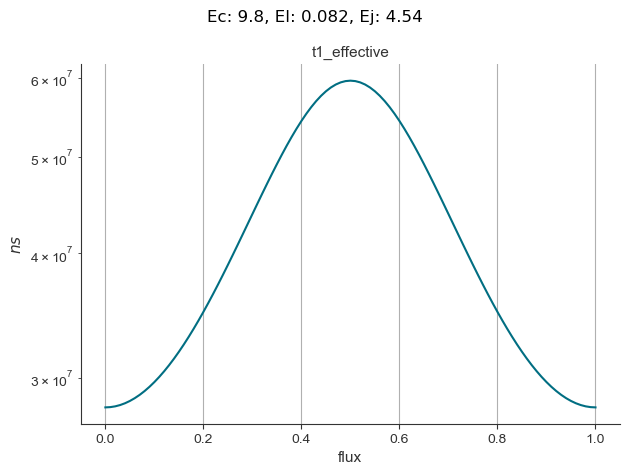

In [293]:
blochnium = sq.Fluxonium(EC= 7, EL = 0.065, EJ= 4.7,flux=0, cutoff=120)
flux_array = np.linspace(0, 1, 101)
fig, ax = blochnium.plot_t1_effective_vs_paramvals(param_name='flux',
                                     param_vals=flux_array,
                                     noise_channels=[('t1_flux_bias_line', dict(M=400)), 't1_inductive', 't1_quasiparticle_tunneling'],
                                     common_noise_options=dict(T=0.015)
                                     )
fig.suptitle(f'Ec: {np.round(fluxonium.EC,3)}, El: {np.round(fluxonium.EL,3)}, Ej: {np.round(fluxonium.EJ,3)}')
fig.tight_layout()

Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

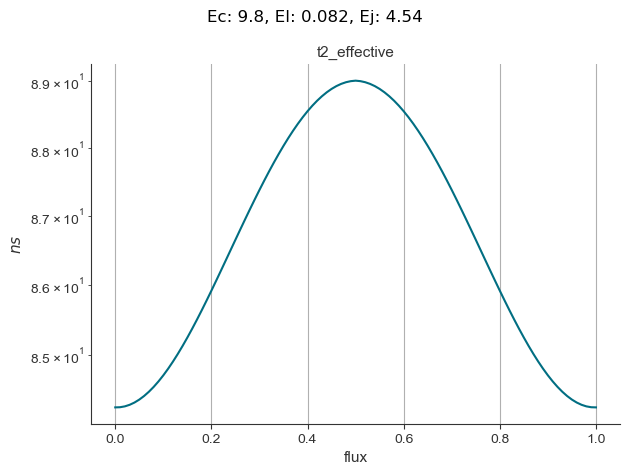

In [ ]:
flux_array = np.linspace(0, 1, 101)
fig, ax = fluxonium.plot_t2_effective_vs_paramvals(param_name='flux',
                                     param_vals=flux_array,
                                     noise_channels=['tphi_1_over_f_cc','tphi_1_over_f_flux','t1_capacitive','t1_charge_impedance',('t1_flux_bias_line', dict(M=1000)), 't1_inductive', 't1_quasiparticle_tunneling'],
                                     common_noise_options=dict(T=0.015)
                                     )
fig.suptitle(f'Ec: {np.round(fluxonium.EC,3)}, El: {np.round(fluxonium.EL,3)}, Ej: {np.round(fluxonium.EJ,3)}')
fig.tight_layout()

Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

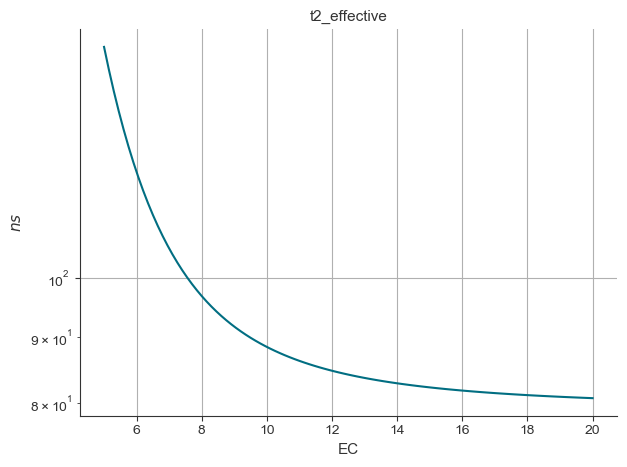

In [270]:
Ec_array = np.linspace(5, 20, 101)
fig, ax = fluxonium.plot_t2_effective_vs_paramvals(param_name='EC',
                                     param_vals=Ec_array,
                                     noise_channels=['tphi_1_over_f_cc','tphi_1_over_f_flux','t1_capacitive','t1_charge_impedance',('t1_flux_bias_line', dict(M=1000)), 't1_inductive', 't1_quasiparticle_tunneling'],
                                     common_noise_options=dict(T=0.015)
                                     )